## Financial Inclusion

* Financial inclusion means that individuals and businesses have access to useful and affordable financial products and services that meet their needs – transactions, payments, savings, credit and insurance – delivered in a responsible and sustainable way.

* Financial inclusion remains one of the main obstacles to economic and human development in Africa.

### OBJECTIVE OF PROJECT

* The objective of this project is to create a machine learning model to predict which individuals are most likely to have or use a bank account. The models and solutions developed can provide an indication of the state of financial inclusion in Kenya, Rwanda, Tanzania and Uganda, while providing insights into some of the key factors driving individuals’ financial security.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate, GridSearchCV

In [ ]:
#Path to the required files 
path_test = r'Test.csv'
path_train = r'Train.csv'
path_variable = r'VariableDefinitions.csv'

In [ ]:
# Read csv and convert to DataFrames
train_csv = pd.read_csv(path_train)
test_csv = pd.read_csv(path_test)
variables_csv = pd.read_csv(path_variable)

train_df = pd.DataFrame(train_csv)
test_df = pd.DataFrame(test_csv)
variable_df = pd.DataFrame(variables_csv)

In [ ]:
train_df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [ ]:
test_df.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [ ]:
variable_df.head()

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"


## Exploratory Data Analysis

In [ ]:
## Write a function to display the dataset information and descriptions

def data_info(df):

  print('*'*30, 'head'.upper(), '*'*30)
  print(df.head())


  print('*'*30, 'columns'.upper(), '*'*30)
  print(df.columns)

  print('*'*30, 'data type'.upper(), '*'*30)
  print(type(df))

  print('*'*30, 'Shape'.upper(), '*'*30)
  print(df.shape)

  print('*'*30, 'Info'.upper(), '*'*30)
  print(df.info())

  print('*'*30, 'isnull'.upper(), '*'*30)
  print(df.isnull().any())

  print('*'*30, 'isnull count'.upper(), '*'*30)
  print(df.isnull().any().value_counts())

  print('*'*30, 'Description'.upper(), '*'*30)
  print(df.describe())




In [ ]:
data_info(train_df)

****************************** HEAD ******************************
  country  year    uniqueid bank_account location_type cellphone_access  \
0   Kenya  2018  uniqueid_1          Yes         Rural              Yes   
1   Kenya  2018  uniqueid_2           No         Rural               No   
2   Kenya  2018  uniqueid_3          Yes         Urban              Yes   
3   Kenya  2018  uniqueid_4           No         Rural              Yes   
4   Kenya  2018  uniqueid_5           No         Urban               No   

   household_size  age_of_respondent gender_of_respondent  \
0               3                 24               Female   
1               5                 70               Female   
2               5                 26                 Male   
3               5                 34               Female   
4               8                 26                 Male   

  relationship_with_head           marital_status  \
0                 Spouse  Married/Living together   
1      He

## INSIGHT FROM FIRST SNOOP

In [ ]:
# classify each column to its appropriate data type and split
def grab_cols(df, cat_th=10, car_th=20):

  cat_cols = [col for col in df.columns if df[col].dtypes == 'O']
  num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and df[col].dtypes != 'O']
  cat_but_car = [col for col in df.columns if df[col].nunique() > cat_th and df[col].dtypes == 'O']
  cat_cols = cat_cols + num_but_cat
  cat_col = [col for col in cat_cols if col not in cat_but_car]

  num_col = [col for col in df.columns if df[col].dtypes !='O']

  num_col = [col for col in num_col if col not in num_but_cat]

  print(f'Records: {df.shape[0]}')
  print(f'variables: {df.shape[1]}')
  print(f'Categorical columns: {len(cat_cols)}')
  print(f'Numerical columns: {len(num_col)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')

  return cat_cols, num_col, cat_but_car




In [ ]:
cat_cols, num_col, cat_but_car = grab_cols(train_df)

Records: 23524
variables: 13
Categorical columns: 11
Numerical columns: 2
cat_but_car: 1
num_but_cat: 1


In [ ]:
cat_cols 

['country',
 'uniqueid',
 'bank_account',
 'location_type',
 'cellphone_access',
 'gender_of_respondent',
 'relationship_with_head',
 'marital_status',
 'education_level',
 'job_type',
 'year']

In [ ]:
num_col

['household_size', 'age_of_respondent']

In [ ]:
cat_but_car

['uniqueid']

## Summary Analysis for Categorical Column



In [ ]:
def summary_cat(df, col, plot=False):

  print('*'*20, col.upper(), '*'*20)
  print(pd.DataFrame({col.upper(): df[col].value_counts(), 'Ratio %': round(100*(df[col].value_counts() / len(df)))}))

  if plot:
    sns.countplot(x=df[col])
    plt.ylabel('COUNT')
    plt.xlabel(col.upper())
    plt.show(block=True)


******************** COUNTRY ********************
          COUNTRY  Ratio %
Rwanda       8735     37.0
Tanzania     6620     28.0
Kenya        6068     26.0
Uganda       2101      9.0


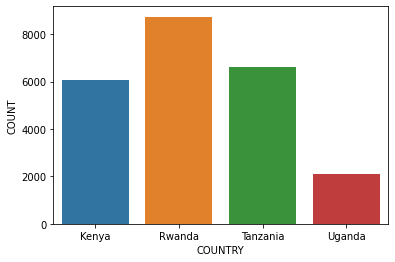

******************** UNIQUEID ********************
               UNIQUEID  Ratio %
uniqueid_1            4      0.0
uniqueid_1413         4      0.0
uniqueid_1411         4      0.0
uniqueid_1410         4      0.0
uniqueid_1409         4      0.0
...                 ...      ...
uniqueid_7318         1      0.0
uniqueid_7317         1      0.0
uniqueid_7316         1      0.0
uniqueid_7315         1      0.0
uniqueid_8759         1      0.0

[8735 rows x 2 columns]


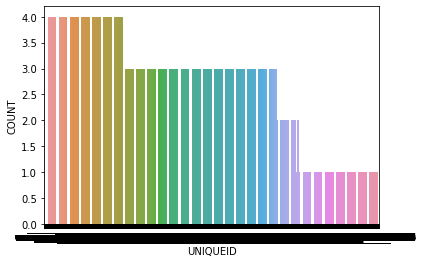

******************** BANK_ACCOUNT ********************
     BANK_ACCOUNT  Ratio %
No          20212     86.0
Yes          3312     14.0


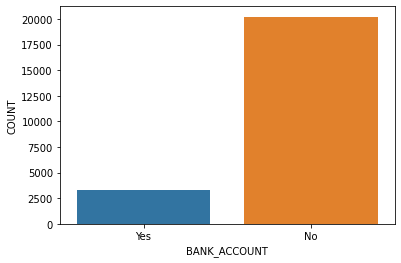

******************** LOCATION_TYPE ********************
       LOCATION_TYPE  Ratio %
Rural          14343     61.0
Urban           9181     39.0


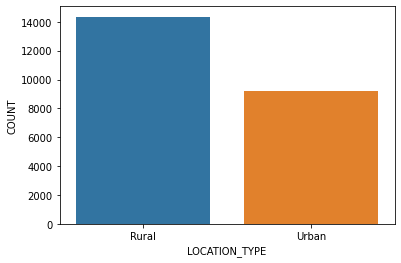

******************** CELLPHONE_ACCESS ********************
     CELLPHONE_ACCESS  Ratio %
Yes             17454     74.0
No               6070     26.0


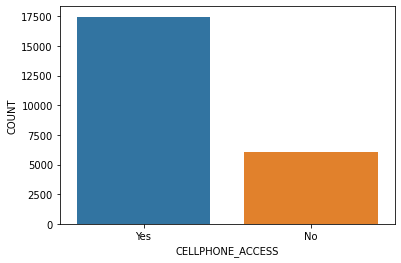

******************** GENDER_OF_RESPONDENT ********************
        GENDER_OF_RESPONDENT  Ratio %
Female                 13877     59.0
Male                    9647     41.0


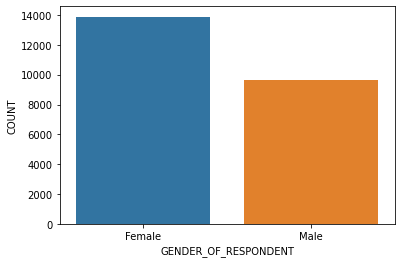

******************** RELATIONSHIP_WITH_HEAD ********************
                     RELATIONSHIP_WITH_HEAD  Ratio %
Head of Household                     12831     55.0
Spouse                                 6520     28.0
Child                                  2229      9.0
Parent                                 1086      5.0
Other relative                          668      3.0
Other non-relatives                     190      1.0


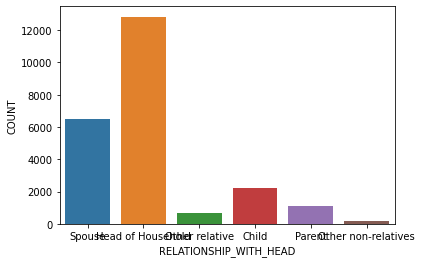

******************** MARITAL_STATUS ********************
                         MARITAL_STATUS  Ratio %
Married/Living together           10749     46.0
Single/Never Married               7983     34.0
Widowed                            2708     12.0
Divorced/Seperated                 2076      9.0
Dont know                             8      0.0


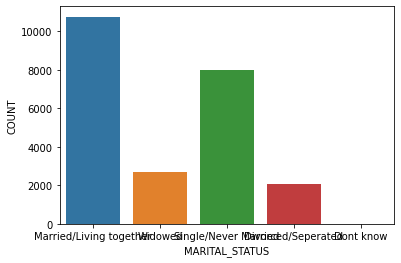

******************** EDUCATION_LEVEL ********************
                                 EDUCATION_LEVEL  Ratio %
Primary education                          12791     54.0
No formal education                         4515     19.0
Secondary education                         4223     18.0
Tertiary education                          1157      5.0
Vocational/Specialised training              803      3.0
Other/Dont know/RTA                           35      0.0


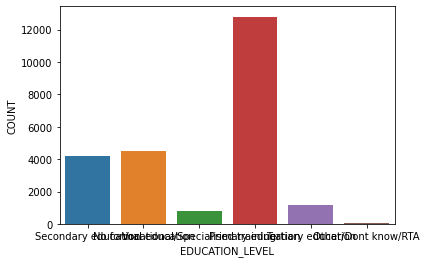

******************** JOB_TYPE ********************
                              JOB_TYPE  Ratio %
Self employed                     6437     27.0
Informally employed               5597     24.0
Farming and Fishing               5441     23.0
Remittance Dependent              2527     11.0
Other Income                      1080      5.0
Formally employed Private         1055      4.0
No Income                          627      3.0
Formally employed Government       387      2.0
Government Dependent               247      1.0
Dont Know/Refuse to answer         126      1.0


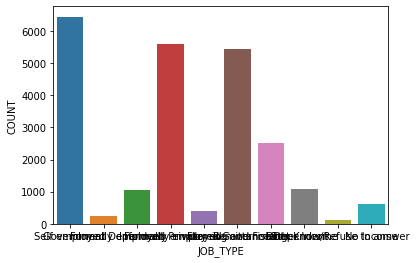

******************** YEAR ********************
      YEAR  Ratio %
2016  8735     37.0
2018  8169     35.0
2017  6620     28.0


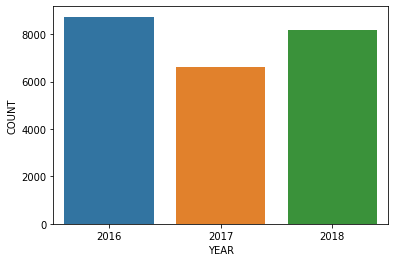

In [ ]:
for col in cat_cols:
  summary_cat(train_df, col, plot=True)


## Summary Analysis for Numerical columns

In [ ]:
def summary_num(df, numerical_col, plot=False):
  print('*'*20, col.upper(), '*'*20)
  print(pd.DataFrame({numerical_col.upper(): round(df[numerical_col].describe().T, 2)}))


  if plot:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.boxplot(y=df[numerical_col])
    plt.ylabel(numerical_col.upper())

    plt.subplot(1,2,2)
    sns.histplot(x=df[numerical_col])
    plt.xlabel(numerical_col.upper())
    plt.show(block=True)

******************** HOUSEHOLD_SIZE ********************
       HOUSEHOLD_SIZE
count        23524.00
mean             3.80
std              2.23
min              1.00
25%              2.00
50%              3.00
75%              5.00
max             21.00


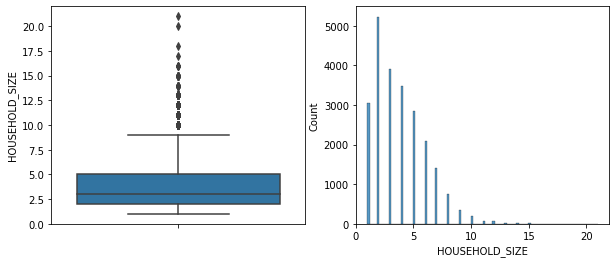

******************** AGE_OF_RESPONDENT ********************
       AGE_OF_RESPONDENT
count           23524.00
mean               38.81
std                16.52
min                16.00
25%                26.00
50%                35.00
75%                49.00
max               100.00


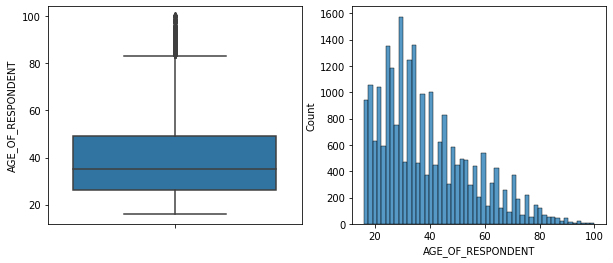

In [ ]:
for col in num_col:
  summary_num(train_df, col, plot=True)

## Data Preprocessing Stage 1 (Encoding and Heatmap)


In [ ]:
train_df2 = train_df.copy(deep=True)

In [ ]:
# Label Encoding for binary classes
def label_encoder(df, binary_col):

  label_encoder = LabelEncoder()
  df[binary_col] = label_encoder.fit_transform(df[binary_col])

  return df

binary_cols = [col for col in train_df2.columns if train_df2[col].nunique() == 2 and train_df2[col].dtypes not in ('int', 'float')]

for col in binary_cols:
    label_encoder(train_df2, col)
  

In [ ]:
train_df2.shape

(23524, 13)

In [ ]:
train_df2.head()

# Location type = {urban: 0, rurual:1}
# Cellphone access = {yes:1, no: 0}
# gender_of_respondent = {male:0, female:1}

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,1,0,1,3,24,0,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,0,0,0,5,70,0,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,1,1,1,5,26,1,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,0,0,1,5,34,0,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,0,1,0,8,26,1,Child,Single/Never Married,Primary education,Informally employed


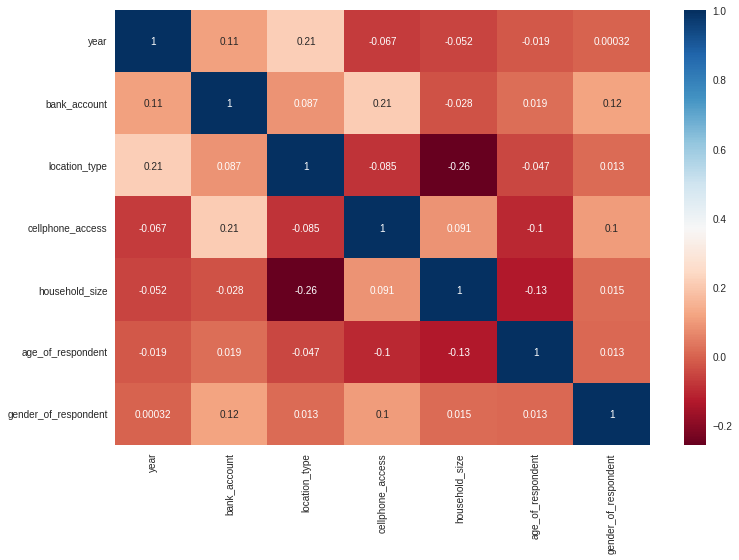

[]

In [ ]:
def high_correlated_cols(dataframe, corr_th=0.90, plot=False):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool_))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    if plot:
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr, cmap='RdBu', annot=True, annot_kws={'fontsize': 10})
        plt.show(block=True)

    return drop_list

high_correlated_cols(train_df2, plot=True)  

In [ ]:
ohe_cols = ['country', 'year', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']

In [ ]:
# OneHot Encoding
def one_hot_encoder(dataframe, ohe_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns = ohe_cols, drop_first=drop_first)
    return dataframe

train_df3 = one_hot_encoder(train_df2, ohe_cols)
train_df3

,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,country_Rwanda,country_Tanzania,country_Uganda,...,education_level_Vocational/Specialised training,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,uniqueid_1,1,0,1,3,24,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,uniqueid_2,0,0,0,5,70,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,uniqueid_3,1,1,1,5,26,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,uniqueid_4,0,0,1,5,34,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,uniqueid_5,0,1,0,8,26,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23519,uniqueid_2113,0,0,1,4,48,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
23520,uniqueid_2114,0,0,1,2,27,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
23521,uniqueid_2115,0,0,1,5,27,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
23522,uniqueid_2116,0,1,1,7,30,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 35 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   uniqueid                                         23524 non-null  object
 1   bank_account                                     23524 non-null  int64 
 2   location_type                                    23524 non-null  int64 
 3   cellphone_access                                 23524 non-null  int64 
 4   household_size                                   23524 non-null  int64 
 5   age_of_respondent                                23524 non-null  int64 
 6   gender_of_respondent                             23524 non-null  int64 
 7   country_Rwanda                                   23524 non-null  uint8 
 8   country_Tanzania                                 23524 non-null  uint8 
 9   country_Uganda                         

In [ ]:
# Seperating the target(dependent variable) from the independent variable

# remember to drop uniqueid
X = train_df3.drop(columns='bank_account', axis=1)


y = train_df3['bank_account']

In [ ]:

X2 = X.drop(columns='uniqueid', axis=1)

array([[-1.07598909,  2.47150504,  0.56673569],
       [-0.60486265, -3.03474837,  2.27977788],
       [ 1.08663391,  2.42027653,  2.4974833 ],
       ...,
       [-0.93506039,  1.94005831,  2.1888621 ],
       [-0.01173232,  3.49744592,  2.38176157],
       [-0.8380486 ,  3.78804288,  2.26250725]])

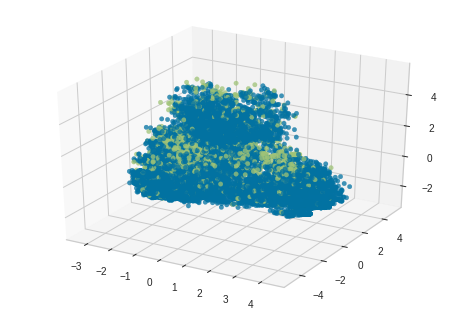

In [ ]:
# import PCA Visualizer 

from yellowbrick.features import PCA

visualizer = PCA(scale=True, projection=3, classes= ['yes', 'no'])

visualizer.fit_transform(X2,y)

In [ ]:
simple = ['location_type', 'cellphone_access', 'household_size' , 'age_of_respondent', 'gender_of_respondent']

simple_X = X2[simple]

array([[-14.78892649,  -1.03163896,   0.28094655],
       [ 31.17069476,   1.76324046,   0.63012424],
       [-12.82587018,   0.94190112,  -0.60598364],
       ...,
       [-11.82503092,   1.01717966,   0.302119  ],
       [ -8.86251629,   3.00459474,   0.35362157],
       [-18.91254482,   5.88599925,  -0.57867631]])

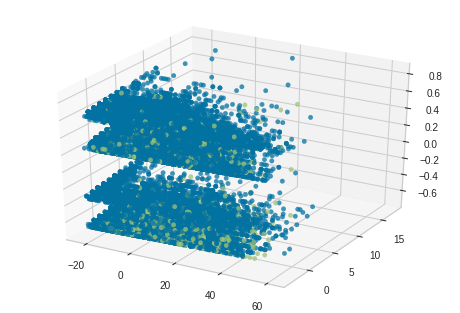

In [ ]:


visualizer2 = PCA(scale=False, projection=3, classes= ['yes', 'no'])

visualizer2.fit_transform(simple_X,y)

FeatureImportances(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f308bf5f5b0>,
                   estimator=RandomForestClassifier(max_depth=3))

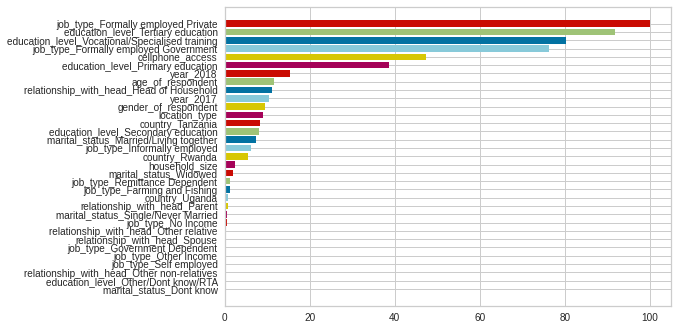

In [ ]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.ensemble import RandomForestClassifier


visualizer3 = FeatureImportances(RandomForestClassifier(max_depth=3), relative=True)
visualizer3.fit(X2, y)

In [ ]:
## Scale columns

scaler = MinMaxScaler()

X2['household_size'] = scaler.fit_transform(X2[['household_size']]) 	
X2['age_of_respondent'] = scaler.fit_transform(X2[['age_of_respondent']])

In [ ]:
X2.head()

,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,country_Rwanda,country_Tanzania,country_Uganda,year_2017,year_2018,...,education_level_Vocational/Specialised training,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,0,1,0.10,0.095238,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.20,0.642857,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,1,1,0.20,0.119048,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,0,1,0.20,0.214286,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0.35,0.119048,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


## Model Training

In [ ]:
## LGBM

# model establishing
lgbm_model = LGBMClassifier(random_state=42).fit(X2, y)

# estimating the errors before hyperparameter optimization
lgbm_cv_results = cross_validate(lgbm_model, X2, y, cv=10, scoring=['accuracy', 'f1', 'roc_auc'])
print('Accuracy:', lgbm_cv_results['test_accuracy'].mean())
print('F1 Score:', lgbm_cv_results['test_f1'].mean())
print('Roc Auc Score:', lgbm_cv_results['test_roc_auc'].mean())

Accuracy: 0.8750656276110105
F1 Score: 0.4467412780511724
Roc Auc Score: 0.841338349995248


In [ ]:
# hypreparameter optimization
print('--'*50)
print(lgbm_model.get_params())
print('--'*50)

lgbm_params = {'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [100, 300, 500, 1000]}

# Using GridSearchCv method
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=10, n_jobs=-1, verbose=True).fit(X2, y)

----------------------------------------------------------------------------------------------------
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
----------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [ ]:
# final model
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=1).fit(X2, y)

# estimating the errors after hyperparameter optimization
lgbm_cv_results = cross_validate(lgbm_final, X2, y, cv=10, scoring=['accuracy', 'f1', 'roc_auc'])
print('Accuracy:', lgbm_cv_results['test_accuracy'].mean())
print('F1 Score:', lgbm_cv_results['test_f1'].mean())
print('Roc Auc Score:', lgbm_cv_results['test_roc_auc'].mean())


Accuracy: 0.8794433614924934
F1 Score: 0.4308369086408311
Roc Auc Score: 0.8412402168386739


## Test Data

In [ ]:
data_info(test_df)

******************** HEAD ********************
  country  year       uniqueid location_type cellphone_access  household_size  \
0   Kenya  2018  uniqueid_6056         Urban              Yes               3   
1   Kenya  2018  uniqueid_6060         Urban              Yes               7   
2   Kenya  2018  uniqueid_6065         Rural               No               3   
3   Kenya  2018  uniqueid_6072         Rural               No               6   
4   Kenya  2018  uniqueid_6073         Urban               No               3   

   age_of_respondent gender_of_respondent relationship_with_head  \
0                 30                 Male      Head of Household   
1                 51                 Male      Head of Household   
2                 77               Female                 Parent   
3                 39               Female      Head of Household   
4                 16                 Male                  Child   

            marital_status                  education_lev

In [ ]:
cat_cols_test, num_col_test, cat_but_car_test = grab_cols(test_df)

Records: 10086
variables: 12
Categorical columns: 10
Numerical columns: 2
cat_but_car: 1
num_but_cat: 1


******************** COUNTRY ********************
          COUNTRY  Ratio %
Rwanda       3745     37.0
Tanzania     2839     28.0
Kenya        2601     26.0
Uganda        901      9.0


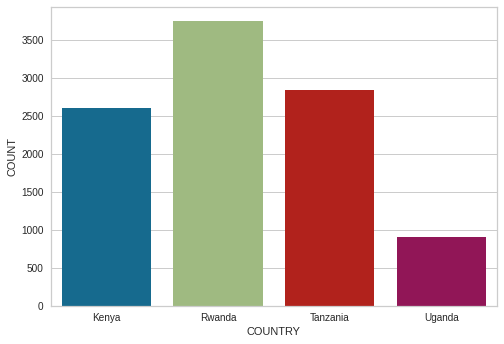

******************** UNIQUEID ********************
                UNIQUEID  Ratio %
uniqueid_8633          3      0.0
uniqueid_8535          3      0.0
uniqueid_8612          3      0.0
uniqueid_8592          3      0.0
uniqueid_8620          3      0.0
...                  ...      ...
uniqueid_10432         1      0.0
uniqueid_10433         1      0.0
uniqueid_10434         1      0.0
uniqueid_10435         1      0.0
uniqueid_3002          1      0.0

[7313 rows x 2 columns]


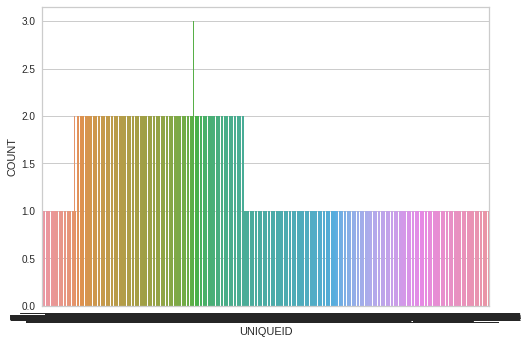

******************** LOCATION_TYPE ********************
       LOCATION_TYPE  Ratio %
Rural           6189     61.0
Urban           3897     39.0


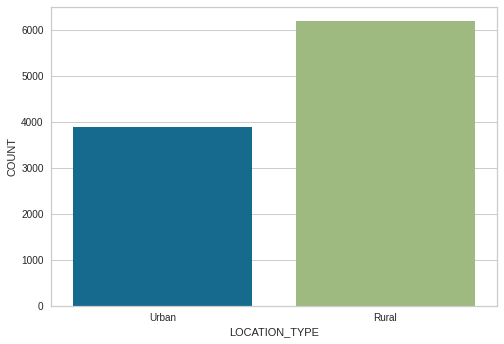

******************** CELLPHONE_ACCESS ********************
     CELLPHONE_ACCESS  Ratio %
Yes              7559     75.0
No               2527     25.0


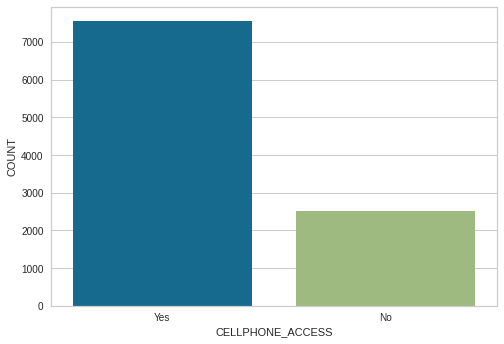

******************** GENDER_OF_RESPONDENT ********************
        GENDER_OF_RESPONDENT  Ratio %
Female                  5847     58.0
Male                    4239     42.0


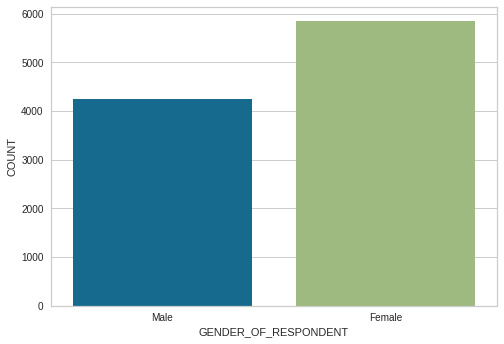

******************** RELATIONSHIP_WITH_HEAD ********************
                     RELATIONSHIP_WITH_HEAD  Ratio %
Head of Household                      5487     54.0
Spouse                                 2845     28.0
Child                                   962     10.0
Parent                                  465      5.0
Other relative                          258      3.0
Other non-relatives                      69      1.0


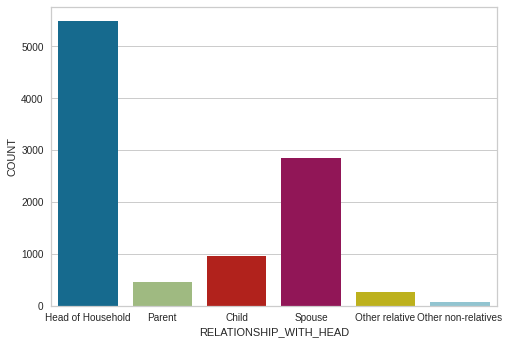

******************** MARITAL_STATUS ********************
                         MARITAL_STATUS  Ratio %
Married/Living together            4663     46.0
Single/Never Married               3447     34.0
Widowed                            1107     11.0
Divorced/Seperated                  868      9.0
Dont know                             1      0.0


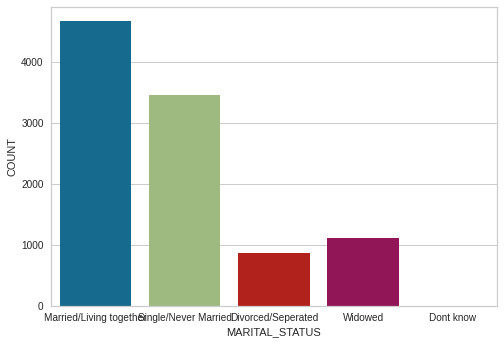

******************** EDUCATION_LEVEL ********************
                                 EDUCATION_LEVEL  Ratio %
Primary education                           5479     54.0
Secondary education                         1902     19.0
No formal education                         1836     18.0
Tertiary education                           492      5.0
Vocational/Specialised training              359      4.0
Other/Dont know/RTA                           18      0.0


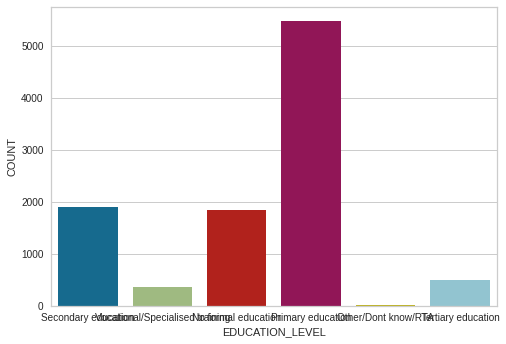

******************** JOB_TYPE ********************
                              JOB_TYPE  Ratio %
Self employed                     2773     27.0
Informally employed               2372     24.0
Farming and Fishing               2370     23.0
Remittance Dependent              1107     11.0
Formally employed Private          444      4.0
Other Income                       423      4.0
No Income                          276      3.0
Formally employed Government       166      2.0
Government Dependent               100      1.0
Dont Know/Refuse to answer          55      1.0


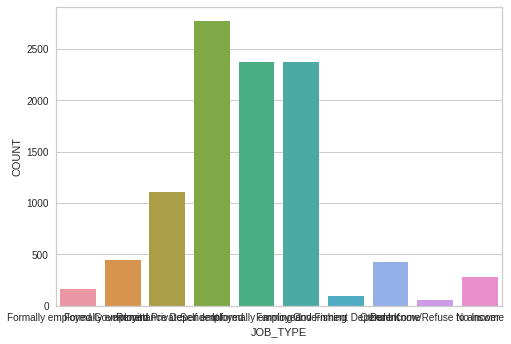

******************** YEAR ********************
      YEAR  Ratio %
2016  3745     37.0
2018  3502     35.0
2017  2839     28.0


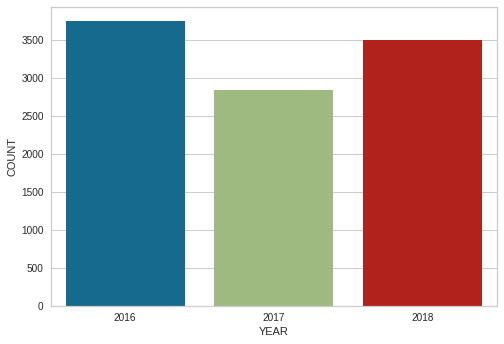

In [ ]:
for col in cat_cols_test:
  summary_cat(test_df, col, plot=True)

******************** HOUSEHOLD_SIZE ********************
       HOUSEHOLD_SIZE
count        10086.00
mean             3.78
std              2.21
min              1.00
25%              2.00
50%              3.00
75%              5.00
max             20.00


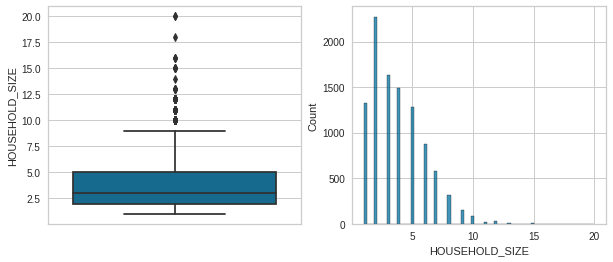

******************** AGE_OF_RESPONDENT ********************
       AGE_OF_RESPONDENT
count           10086.00
mean               38.31
std                16.27
min                16.00
25%                26.00
50%                35.00
75%                48.00
max               100.00


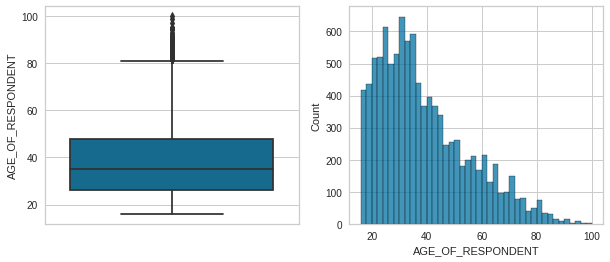

In [ ]:
for col in num_col_test:
  summary_num(test_df, col, plot=True)

In [ ]:

binary_cols_test = [col for col in test_df.columns if test_df[col].nunique() == 2 and test_df[col].dtypes not in ('int', 'float')]



for col in binary_cols_test:
    label_encoder(test_df, col)


In [ ]:
test_df.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,1,1,3,30,1,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,1,1,7,51,1,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,0,0,3,77,0,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,0,0,6,39,0,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,1,0,3,16,1,Child,Single/Never Married,Secondary education,Remittance Dependent


In [ ]:
ohe_cols_test = ['country', 'year', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']

In [ ]:
# OneHot Encoding

test_df2 = one_hot_encoder(test_df, ohe_cols_test)


In [ ]:
test_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10086 entries, 0 to 10085
Data columns (total 34 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   uniqueid                                         10086 non-null  object
 1   location_type                                    10086 non-null  int64 
 2   cellphone_access                                 10086 non-null  int64 
 3   household_size                                   10086 non-null  int64 
 4   age_of_respondent                                10086 non-null  int64 
 5   gender_of_respondent                             10086 non-null  int64 
 6   country_Rwanda                                   10086 non-null  uint8 
 7   country_Tanzania                                 10086 non-null  uint8 
 8   country_Uganda                                   10086 non-null  uint8 
 9   year_2017                              

In [ ]:
X_test = test_df2.drop(columns='uniqueid',axis=1)



In [ ]:
## Scale columns



X_test['household_size'] = scaler.fit_transform(X_test[['household_size']]) 	
X_test['age_of_respondent'] = scaler.fit_transform(X_test[['age_of_respondent']])

## Model Prediction 

In [ ]:
y_predict = lgbm_final.fit()

In [ ]:
test_df2['bank_account'] = lgbm_final.predict(X_test) 

In [ ]:
test_df3 = test_df2.drop(columns='bank_account', axis=1)

In [ ]:
test_df3['bank_account'] = lgbm_final.predict(X_test) 

In [ ]:
test_df3.head()

,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,country_Rwanda,country_Tanzania,country_Uganda,year_2017,...,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed,bank_account
0,uniqueid_6056,1,1,3,30,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,uniqueid_6060,1,1,7,51,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,uniqueid_6065,0,0,3,77,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,uniqueid_6072,0,0,6,39,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,uniqueid_6073,1,0,3,16,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
sub_path = r'SampleSubmission.csv'

sam_submission_df = pd.DataFrame(pd.read_csv(sub_path))

sam_submission_df.head(2)

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0


,uniqueid,bank_account
0,uniqueid_6056,1
1,uniqueid_6060,1
2,uniqueid_6065,0
3,uniqueid_6072,0
4,uniqueid_6073,0


In [ ]:
test_df4= test_df3.copy(deep=True)

test_df4['uniqueid'] = test_df['uniqueid'] + ' x ' + 	test_df['country']   
test_df4.head()

,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,country_Rwanda,country_Tanzania,country_Uganda,year_2017,...,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed,bank_account
0,uniqueid_6056 x Kenya,1,1,3,30,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,uniqueid_6060 x Kenya,1,1,7,51,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,uniqueid_6065 x Kenya,0,0,3,77,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,uniqueid_6072 x Kenya,0,0,6,39,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,uniqueid_6073 x Kenya,1,0,3,16,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
submission_df = test_df4[['uniqueid', 'bank_account']]
submission_df.head()

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0


In [ ]:
submission_df.to_csv('submission2.csv', index=False)